hog feature len 7056


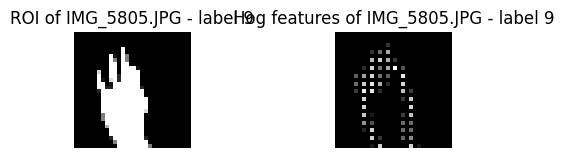

hog feature len 7056


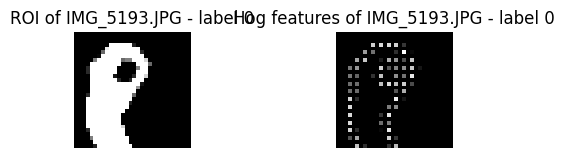

hog feature len 7056


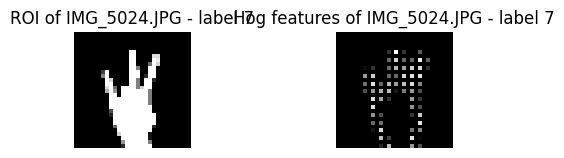

hog feature len 7056


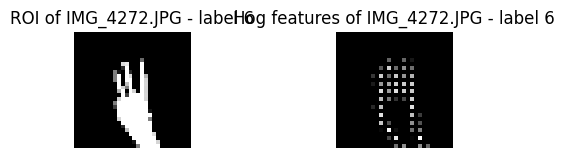

hog feature len 7056


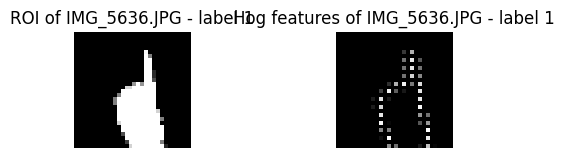

hog feature len 7056


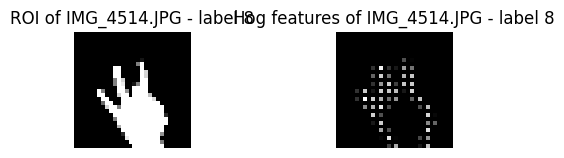

hog feature len 7056


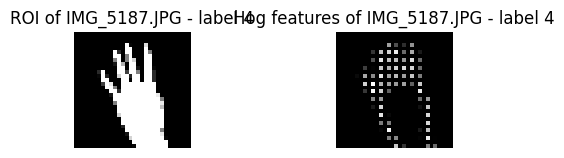

hog feature len 7056


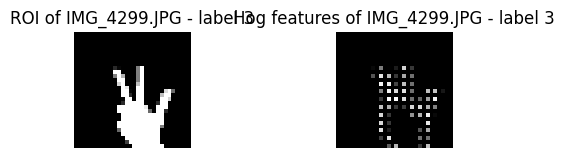

hog feature len 7056


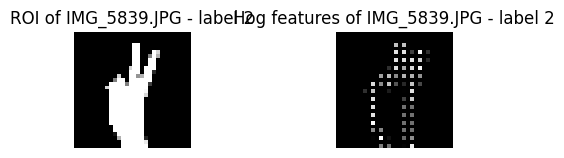

hog feature len 7056


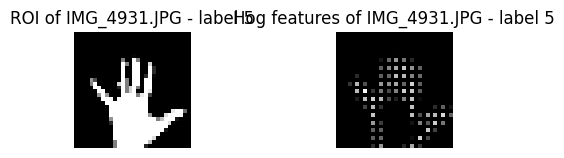

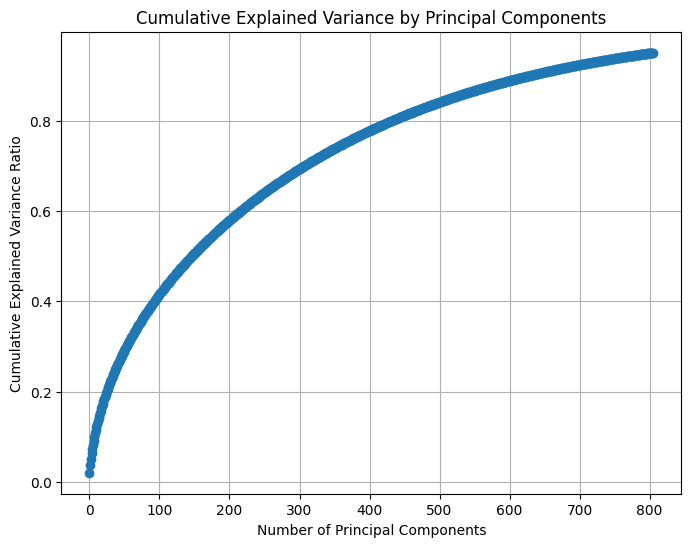

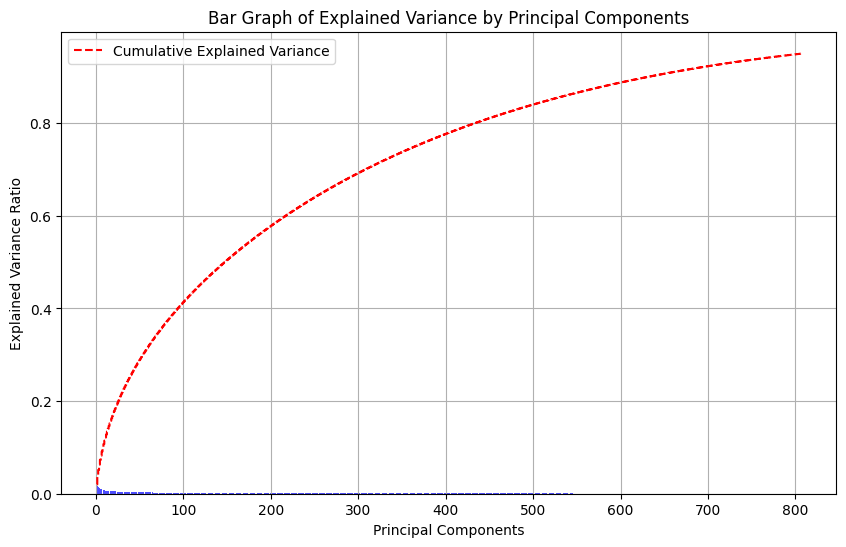

In [1]:
import cv2
import csv
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import graycomatrix, graycoprops, hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

# Preprocessing image function, take RGB color space image as parameter
# Adjusts the saturation channel and applies Gaussian blur
def imagePreprocessing(rgb_image):
  hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
  h, s, v = cv2.split(hsv_image)

  # Adjust saturation (contrast) and apply brightness
  brightness = 0
  contrast = 1.2
  adjusted_s = cv2.addWeighted(s, contrast, np.zeros(s.shape, s.dtype), 0, brightness)
  
  # Apply Gaussian blur to reduce noise
  blurred_adjusted_s = cv2.GaussianBlur(adjusted_s, (1, 1), 0)
  return blurred_adjusted_s

# Function to segment the image using thresholding and erosion
def imageSegmentation(input):
  threshold = 50
  _, binarised_input = cv2.threshold(input, threshold, 255, cv2.THRESH_BINARY)
  kernel = np.ones((2, 2), np.uint8)
  # Use morphological erosion to clean up the segmented output
  eroded_output = cv2.erode(binarised_input, kernel, iterations=1)
  return eroded_output

# Function to calculate GLCM (Gray Level Co-occurrence Matrix) features from a region of interest (ROI)
def GLCMCalculator(roi):
    g = graycomatrix(roi, [0, 1], [0, np.pi/2], levels=256)
    
    # Calculate GLCM properties and convert them to float for further processing
    contrast = round(float(np.mean(graycoprops(g, 'contrast'))), 2)
    energy = round(float(np.mean(graycoprops(g, 'energy'))), 2)
    homogeneity = round(float(np.mean(graycoprops(g, 'homogeneity'))), 2)
    correlation = round(float(np.mean(graycoprops(g, 'correlation'))), 2)
    dissimilarity = round(float(np.mean(graycoprops(g, 'dissimilarity'))), 2)
    ASM = round(float(np.mean(graycoprops(g, 'ASM'))), 2)
    # Return GLCM features as a list
    return [contrast, dissimilarity, homogeneity, ASM, energy, correlation]

# Function to calculate HOG (Histogram of Oriented Gradients) features from a gray-scale ROI
def HOGCalculator(gray_roi, image_name, label, show_plot):
    resized_gray_roi = cv2.resize(gray_roi, (30, 30))
    
    # Extract HOG features and the HOG image
    features, hog_image = hog(
        resized_gray_roi,
        orientations = 9,
        pixels_per_cell=(2, 2),
        cells_per_block=(2, 2),
        visualize=True,
    )
    # Display the HOG features and the original region of interest (ROI)
    if show_plot:
      print("hog feature len", len(features))
      plt.figure(figsize=(8,3))
      
      plt.subplot(2,3,1)
      plt.title(f"ROI of {image_name} - label {label}")
      plt.imshow(resized_gray_roi, 'gray')
      plt.axis('off')
      
      plt.subplot(2,3,2)
      plt.title(f"Hog features of {image_name} - label {label}")
      plt.imshow(hog_image, 'gray')
      plt.axis('off')
      
      plt.tight_layout()
      plt.show()
    
    # Convert HOG features to float and return them as a list
    features = [round(float(f), 2) for f in features]
    return features
  
# Function to perform PCA (Principal Component Analysis) on HOG features
# Reduces dimensionality of the HOG features while keeping 95% of the variance
def PCAHOGCalculator(HOG_features_list, n_component= 0.95):
  name_list = [item[0] for item in HOG_features_list]
  features_list = [item[1] for item in HOG_features_list]
  label_list = [item[2] for item in HOG_features_list]
  
  scaler = StandardScaler()
  standardized_features_list = scaler.fit_transform(features_list)
  
  pca = PCA(n_components=n_component)
  PCA_HOG_features = pca.fit_transform(standardized_features_list)
  
  combined_list = []
  
  for name, pca_features, label in zip(name_list, PCA_HOG_features, label_list):
    rounded_pca_features = [round(float(f), 2) for f in pca_features]
    combined_list.append([name] + [rounded_pca_features] + [label])

  plt.figure(figsize=(8,6))
  plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
  plt.title('Cumulative Explained Variance by Principal Components')
  plt.xlabel('Number of Principal Components')
  plt.ylabel('Cumulative Explained Variance Ratio')
  plt.grid()
  plt.show()
  
  plt.figure(figsize=(10, 6))
  components = range(1, len(pca.explained_variance_ratio_)+1)
  plt.bar(components, pca.explained_variance_ratio_, color='blue', alpha=0.7)
  plt.step(components, np.cumsum(pca.explained_variance_ratio_), where='mid', linestyle='--', color='red', label='Cumulative Explained Variance')
  plt.xlabel('Principal Components')
  plt.ylabel('Explained Variance Ratio')
  plt.title('Bar Graph of Explained Variance by Principal Components')
  plt.grid(True)
  plt.legend()
  plt.show()
    
  return combined_list

# Function to write the features to a CSV file
# If the file doesn't exist, it writes the header first
def writeFeaturesToCSV(csv_name, row, header):
    file_exists = os.path.isfile(csv_name)
    with open(csv_name, mode="a", newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
          writer.writerow(header) # Write header if the file doesn't exist
        writer.writerow([row[0]] + list(row[1]) + [row[2]]) # Write the feature row

# Main dataset directory and CSV filenames
image_dataset_name = "Sign-Language Digit Dataset"

GLCM_csv_filename = "MLP301BachDuongGLCMFeatures.csv"
HOG_csv_filename = "MLP301BachDuongHOGFeatures.csv"
PCA_HOG_csv_filename = "MLP301BachDuongPCA_HOG_Features.csv"

GLCM_features_list = []
HOG_features_list = []

# ------------------------------------- Start of main function ---------------------------------------------
# Loop through each folder (label) and process images
for label in os.listdir(image_dataset_name):
  label_path = os.path.join(image_dataset_name, label)
  if os.path.isdir(label_path) and not label.startswith("."):
    is_first_image = True
    # Loop through each image in the label folder
    for image_name in os.listdir(label_path):
      image_path = os.path.join(label_path, image_name)
      bgr_image = cv2.imread(image_path)
      rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
      
      # Preprocess the image and segment it
      preprocessed_image = imagePreprocessing(rgb_image)
      roi = imageSegmentation(preprocessed_image)

      # Extract GLCM and HOG features
      GLCM_features = GLCMCalculator(roi)
      GLCM_features_list.append([image_name] + [GLCM_features] + [label])

      HOG_features = HOGCalculator(roi, image_name, label, is_first_image)
      HOG_features_list.append([image_name] + [HOG_features] + [label])
      is_first_image = False

# Perform PCA on the HOG features
PCA_HOG_features_list = PCAHOGCalculator(HOG_features_list)

# Define headers for the CSV files
GLCM_features_header = ["Images", "Contrast", "Dissimilarity", "Homogeneity", "ASM", "Energy", "Correlation", "Label"]
HOG_features_header = ["Images"] + [f"Feature {i+1}" for i in range(len(HOG_features_list[0][1]))] + ["Label"]
PCA_HOG_features_header = ["Images"] + [f"Feature {i+1}" for i in range(len(PCA_HOG_features_list[0][1]))] + ["Label"]

# Write GLCM, HOG, and PCA HOG features to their respective CSV files
for GLCM_row in GLCM_features_list:
  writeFeaturesToCSV(GLCM_csv_filename, GLCM_row, GLCM_features_header)
for HOG_row in HOG_features_list:
  writeFeaturesToCSV(HOG_csv_filename, HOG_row, HOG_features_header)
for PCA_HOG_row in PCA_HOG_features_list:
  writeFeaturesToCSV(PCA_HOG_csv_filename, PCA_HOG_row, PCA_HOG_features_header)